<h1>Detecção de fraude</h1>

<h2>Introdução</h2>
<font size=3>Como dataset para este case vamos utilizar o <a href='https://www.kaggle.com/ntnu-testimon/paysim1'>Synthetic Financial Datasets For Fraud Detection</a>, que são dados sintéticos da Paysim, onde ela agregada dados de transações monetárias de datasets privados para simular dados sintéticos que compreendam os mesmos comportamentos dos dados reais.</font>


<a name='IND'></a>
<h2>Índice</h2>
<font size=3>
<ol>
    <li><a href='#EDA'>Análise Exploratória</a></li>
    <ol>
        <li><a href='#TYPE'>Type</a></li>
        <li><a href='#AMOUNT'>Amount</a></li>
        <li><a href='#BALANCE'>Balance</a></li>
        <li><a href='#FLAGGED'>Is Flagged Fraud</a></li>
    </ol>
    <li><a href='#FEAT'>Feature Engineering</a></li>
    <li><a href='#MODEL'>Modelo</a></li>
</ol>
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, recall_score, f1_score
from skopt import forest_minimize

pd.options.display.max_columns = 999

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<font size=3>Mas o que são essas variáveis?<br>
Abaixo vamos explicar cada uma:
<ul>
    <li><b>step</b>: a hora referente a captura, vai de 1 à 744 (total de 30 dias)</li>
    <li><b>type</b>: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.</li>
    <li><b>amount</b>: valor da transação na moeda local.</li>
    <li><b>nameOrig</b>: cliente que iniciou a transação.</li>
    <li><b>oldbalanceOrg</b>: saldo inicial antes da transação.</li>
    <li><b>newbalanceOrig</b>: saldo após a transação.</li>
    <li><b>nameDest</b>: cliente destinatário da transação</li>
    <li><b>oldbalanceDest</b>: saldo inicial do destinatário antes da transação. Não há informações caso o destinatário seja um comerciante (começa com a letra M).</li>
    <li><b>newbalanceDest</b>: saldo do destinatário após a transação. Não há informações caso o destinatário seja um comerciante (começa com a letra M).</li>
    <li><b>isFraud</b>: transações feitas por agentes fraudulentos, neste dado simulado os agentes tenta fraudar invadindo a conta e zerando o saldo transferindo para outras contas.</li>
    <li><b>isFlaggedFraud</b>: modelo de negócios que tenta impedir uma tentativa ilegal. Tentativa ilegal é um tentativa de transferir mais de 200.000 em uma única transação.</li>
</ul>

</font>

In [3]:
print('Linhas:\t {}\nColunas: {}'.format(df.shape[0], df.shape[1]))

Linhas:	 6362620
Colunas: 11


<font size=3>Verificando as quantidades de nulos no dataset, porém como podemos ver não há nulos.</font>

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<font size=3>Verificando a quantidade e porcentagem de fraudes no dataset.</font>

In [5]:
print('Quantidade de fraudes: {}\nPorcentagem de fraudes: {:.2f}%'.format(df['isFraud'].sum(), 
                                                                          (df['isFraud'].sum()/df.shape[0])*100))

Quantidade de fraudes: 8213
Porcentagem de fraudes: 0.13%


<a name='EDA'></a>
<h2>Análise Exploratória</h2>
<font size=3>Com os dados carregados vamos começar a EDA antes de criar o modelo que tentará prever se a transação é fraude.</font>
<a name='TYPE'></a>
<h3>Type</h3>    
<font size=3>Vamos começar com a variável <code>type</code> verificando as porcentagens de cada categoria para quando é fraude e não fraude. Assim podemos ver que quando é fraude o tipo de transação é <i>CASH_OUT</i> ou <i>TRANSFER</i>, enquanto não é fraude temos mais tipos de transações, o que faz sentido já que o fraudador quer transferir o saldo da conta invadida para uma conta de sua posse a após isso sacar o dinheiro.</font> 

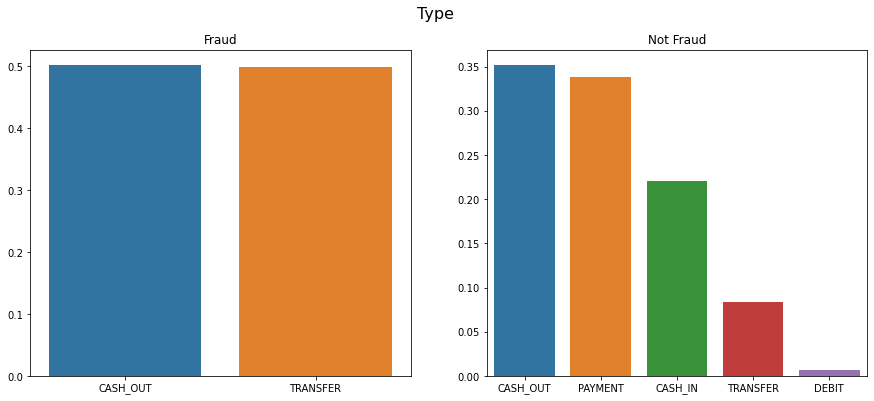

In [6]:
fraud = df[df['isFraud']==1]
n_fraud = df[df['isFraud']!=1]
fraud = fraud['type'].value_counts(normalize=True)
n_fraud = n_fraud['type'].value_counts(normalize=True)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Type', fontsize=16)
ax[0].set_title('Fraud')
sns.barplot(x=fraud.index, y=fraud.values, ax=ax[0])
ax[1].set_title('Not Fraud')
sns.barplot(x=n_fraud.index, y=n_fraud.values, ax=ax[1]);

<a name='AMOUNT'></a>
<h3>Amount</h3>
<font size=3>Como podemos ver quando não é fraude a maioria das transações são valores menores, já quando é fraude a maioria é valores menores também porém há uma parcela de valores maiores.</font>

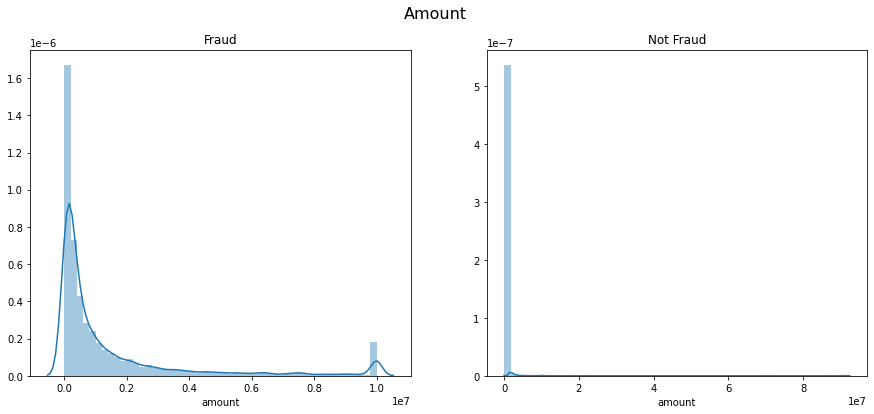

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Amount', fontsize=16)
ax[0].set_title('Fraud')
sns.distplot(df[df['isFraud']==1]['amount'], ax=ax[0])
ax[1].set_title('Not Fraud')
sns.distplot(df[df['isFraud']==0]['amount'], ax=ax[1]);

<a name='BALANCE'></a>
<h3>Balance</h3>
<font size=3>Como visto na variável <code>type</code> o comportamento do fraudador é transferir o dinheiro para outra conta e depois sacar a grana. Então em uma transação fraudulenta a variável <code>newbalanceOrig</code> deve ser 0 e a variável <code>oldbalanceDest</code> também deve ser 0 já que o fraudador deve retirar o dinheiro, pois a qualquer momento a conta pode ser bloqueado.</font>

In [8]:
fraud = df[df['isFraud']==1]
print('newbalanceOrig')
print(fraud[fraud['type']=='TRANSFER']['newbalanceOrig'].value_counts().head())
print('\noldbalanceDest')
print(fraud[fraud['type']=='TRANSFER']['oldbalanceDest'].value_counts().head())

newbalanceOrig
0.00           3938
10399045.08       3
17316255.05       3
19585040.37       3
1343002.08        2
Name: newbalanceOrig, dtype: int64

oldbalanceDest
0.00          4092
260806.21        1
535933.16        1
2122336.55       1
1283762.85       1
Name: oldbalanceDest, dtype: int64


<a name='FLAGGED'></a>
<h3>is Flagged Fraud</h3>
<font size=3>Vamos verificar a importância dessa regra de negócio, quando a transação for maior que 200.000 é ativada, usando as métricas de <code>precision</code> e <code>recall</code>.</font>

In [9]:
string = 'Quantidade de flags: {}\nMenor transação: {}\nMaior transação: {}'
print(string.format(df[df['isFlaggedFraud']==1]['amount'].count(),
                    df[df['isFlaggedFraud']==1]['amount'].min(),
                    df[df['isFlaggedFraud']==1]['amount'].max()))
# df[df['isFlaggedFraud']==1]['amount'].count()

Quantidade de flags: 16
Menor transação: 353874.22
Maior transação: 10000000.0


In [10]:
flagged = df[df['isFlaggedFraud']==1]
string = 'Precision: {:.2f}%\nRecall: {:.2f}%'
prec = (flagged.shape[0]/flagged[flagged['isFraud']==1].shape[0])*100
rec = (flagged[flagged['isFraud']==1].shape[0]/df[df['isFraud']==1].shape[0]) * 100
print(string.format(prec, rec))

Precision: 100.00%
Recall: 0.19%


<font size=3>Podemos ver a regra é bem focada na experiência onde abre a mão da recall, ou seja, acertar todas as fraudes, para ter uma ótima precisão i.e. quando "flaggear" como fraude ter mais probabilidade de ser fraude.<br>
E por último tem um <i>stripplot</i> que vi no <a href='https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services'>Kaggle</a> que mostra como as transações são homogêneas pelo tempo e também com a quantidade de <code>Transfer</code> e <code>Cash out</code>.</font>

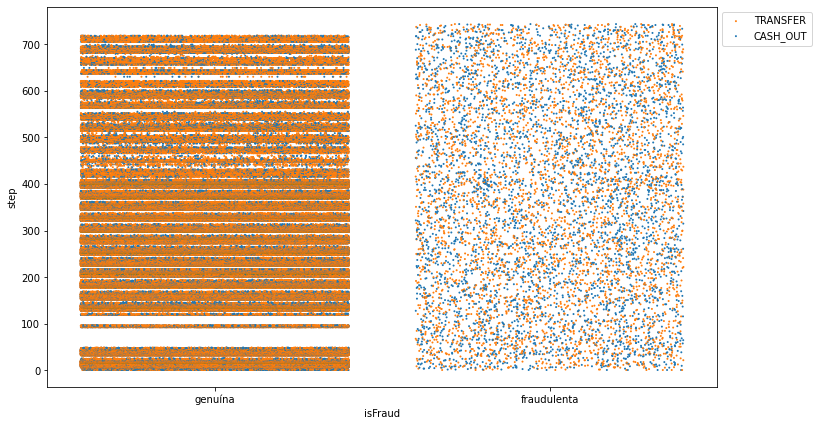

In [61]:
X = df.loc[(df['type'] == 'TRANSFER') | (df['type'] == 'CASH_OUT')]

Y = X['isFraud']
del X['isFraud']

X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

X.loc[X['type'] == 'TRANSFER', 'type'] = 0
X.loc[X['type'] == 'CASH_OUT', 'type'] = 1
X['type'] = X['type'].astype(int)

limit = len(X)
plt.figure(figsize=(12,7))
sns.stripplot(x=Y[:limit], y=X['step'][:limit], hue=X['type'][:limit], jitter=0.4, size=2)
plt.xticks(np.arange(2), ['genuína', 'fraudulenta'])
plt.legend(['TRANSFER', 'CASH_OUT'], bbox_to_anchor=(1, 1), loc='upper left');

<br>
<font size=3><a href='#IND'>Voltar para o índice</a></font>

<a name='FEAT'></a>
<h2>Feature Engineering</h2>
<font size=3>Agora vamos tratar as variáveis e criar algumas que consideramos que pode ajudar o modelo na sua decisão. Primeiro vamos resolver os casos em que <code>oldbalanceDest</code> e <code>newbalanceDest</code> são 0 porém o <code>amount</code> é maior que 0 e o <code>nameDest</code> não é um merchant, nesses casos vamos deixar o valor em -1.</font>

In [11]:
df.loc[(df['oldbalanceDest']==0) & (df['newbalanceDest']==0) & (df['amount']>0) & \
       (np.logical_not((df['nameDest'].str.contains('M')))), \
       ['oldbalanceDest', 'newbalanceDest']] = -1

<font size=3>Será que temos o mesmo caso do saldo da conta de Origem? E a resposta é sim, e vamos fazer da mesma forma que fizemos para a conta de Destino.</font>

In [12]:
df.loc[(df['oldbalanceOrg']==0) & (df['newbalanceOrig']==0) & (df['amount']>0), \
       ['oldbalanceDest', 'newbalanceDest']] = -1

<font size=3>Outra variável é se o destinatário é um comerciante ou não.</font>

In [13]:
df['isMerchant'] = df['nameDest'].apply(lambda x: 1 if x.find('M')!=-1 else 0)
df['isMerchant'].sum()

2151495

<font size=3>Vamos separar entre treino e teste. Como temos o step que são a hora da captura, será escolhido uma hora como limiar para treino e teste, ou seja, dados antes desta hora será treino e depois será teste, afim de manter uma distribuição de 80/20.</font>

In [14]:
df_train = df[df['step']<=370]
X_train = df_train.drop('isFraud', axis=1)
y_train = df_train['isFraud']
df_test = df[df['step']>370]
X_test = df_test.drop('isFraud', axis=1)
y_test = df_test['isFraud']
print('X_train: {}\ny_train: {}\nX_test: {}\ny_test: {}'.format(X_train.shape, y_train.shape, 
                                                                X_test.shape, y_test.shape))

X_train: (5227985, 11)
y_train: (5227985,)
X_test: (1134635, 11)
y_test: (1134635,)


<font size=3>Vamos tratar a variável <code>type</code> utilizando o <code>OneHotEncoder</code> para os dados de teste e treino.</font>

In [15]:
# Dataset de Treino
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
cat_feat = enc.fit_transform(X_train[['type']])
cat_feat = pd.DataFrame(cat_feat, columns=enc.get_feature_names(['type']))
X_train = pd.merge(X_train, cat_feat, left_index=True, right_index=True).drop('type', axis=1)

# Dataset de Teste
cat_feat = enc.transform(X_test[['type']])
cat_feat = pd.DataFrame(cat_feat, columns=enc.get_feature_names(['type']))
cat_feat.index = X_test.index
X_test = pd.merge(X_test, cat_feat, left_index=True, right_index=True).drop('type', axis=1)

<font size=3>Outra variável que considero importante criarmos, é se já houve uma transação fraudulenta tanto para o <code>nameOrig</code> quanto para o <code>nameDest</code>, porém devido a quantidade de registros criar essas variáveis demandaria muito tempo.</font>

<font size=3>
<code>name_orig = []
name_dest = []
for step in range(1, df['step'].max()+1):
    df_step = df[df['step']==step]
    history = df.loc[(df['isFraud']==1) & (df['step']>=step-168) & (df['step']&ltstep)]
    for key, values in df.iterrows():
        display.clear_output(wait=False)
        display.display('{}/{}'.format(step, df['step'].max()))
        display.display('{}/{}'.format(key, df_step.shape[0]))
        origin = values['nameOrig']
        dest = values['nameDest']
        name_orig.append(history.loc[(df['nameOrig']==origin)].shape[0])
        name_dest.append(history.loc[(df['nameDest']==dest)].shape[0])
</code>
<font>

<font size=3><a href='#IND'>Voltar para o índice</a></font>
<a name='MODEL'></a>
<h2>Modelo</h2>

<font size=3>Como neste caso as classes não estão balanceadas vamos computar um peso para passarmos como parâmetro para a <code>scale_pos_weight</code>.</font>

In [16]:
weight = df[df['isFraud']==0].shape[0]/(1.0 * df[df['isFraud']==1].shape[0])

<font size=3>Inicialmente não vamos utilizar as variáveis <code>nameOrig</code> e <code>nameDest</code> então neste caso vamos remove-las dos datasets.</font>

In [17]:
X_train.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
X_test.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

<font size=3>Com tudo feito vamos dar um <i>fit</i> do modelo para termos uma noção do valor das métricas para depois ajustarmos os hiperparâmetros. Infelizmente utilizando a variável <code>scale_pos_weight</code> a performance da LGBM degrada, por isso vamos usar <code>class_weight</code> como <code>balanced</code>.</font>

In [18]:
lgbm = LGBMClassifier(max_depth=5, class_weight='balanced', random_state=72)
lgbm.fit(X_train, y_train)
proba = lgbm.predict_proba(X_test)[:,1]
pred = lgbm.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


<font size=3>As métricas que vamos utilizar serão <code>average precision</code>, <code>recall</code> e <code>f1 score</code>, como os dados estão bem desbalanceados é melhor utilizarmos essas métricas do que a <code>roc auc</code> e <code>accuracy</code>, pois são robustas para desbalanceamento.</font>

In [19]:
aps = average_precision_score(y_test, proba)
rec = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
print('avg precision:\t{:.5f}\nrecall: \t{:.5f}\nf1 score: \t{:.5f}'.format(aps, rec, f1))

avg precision:	0.94261
recall: 	0.99779
f1 score: 	0.60204


<font size=3>Como as métricas do modelo sem tunning como baseline, vamos fazer uma <i>otimização bayesiana</i> para tentarmos melhorar essas métricas.</font>

In [20]:
def tune_lgbm(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    
    lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                          min_child_samples=min_child_samples, subsample=subsample,
                          colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators, random_state=0, 
                          class_weight="balanced", n_jobs=6)
    lgbm.fit(X_train, y_train)
    
    proba_lgbm = lgbm.predict_proba(X_test)[:,1]
    
    pred_lgbm = lgbm.predict(X_test)
    
    print(recall_score(y_test, pred_lgbm), f1_score(y_test, pred_lgbm), sep='\t')
    
    return -average_precision_score(y_test, proba_lgbm)

space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100, 500)] # n_estimators

res = forest_minimize(tune_lgbm, space, random_state=72, n_random_starts=20, n_calls=30, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.0988609027885323, 6, 6, 0.6659248448311085, 0.06946698880534692, 385]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.9597447226313206	0.1657165864926148
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 120.7209
Function value obtained: -0.5394
Current minimum: -0.5394
Iteration No: 2 started. Evaluating function at random point.
[0.027048773459553185, 9, 17, 0.9915345264646779, 0.7608844023983169, 224]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.9982817869415808	0.6811824805292689
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 186.7485
Function value obtained: -0.9732
Current minimum: -0.9732
Iteration No: 3 started. Evaluating function at random point.
[0.005962054013345367, 1, 13, 0.07097309778582109, 0.49701597208191545, 259]
[LightGBM] [Warning] baggin

<font size=3>Feita a otimização bayesiana vamos pegar os parâmetros que geraram os melhores resultados e treinar o modelo final.</font>

In [21]:
params = res.x
lgbm = LGBMClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_samples=params[2],
                      subsample=params[3], colsample_bytree=params[4], bagging_freq=1, n_estimators=params[5], random_state=0,
                      class_weight="balanced", n_jobs=6)
lgbm.fit(X_train, y_train)
proba = lgbm.predict_proba(X_test)[:,1]
pred = lgbm.predict(X_test)
aps = average_precision_score(y_test, proba)
rec = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
print('avg precision:\t{:.5f}\nrecall: \t{:.5f}\nf1 score: \t{:.5f}'.format(aps, rec, f1))

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
avg precision:	0.97319
recall: 	0.99828
f1 score: 	0.68118


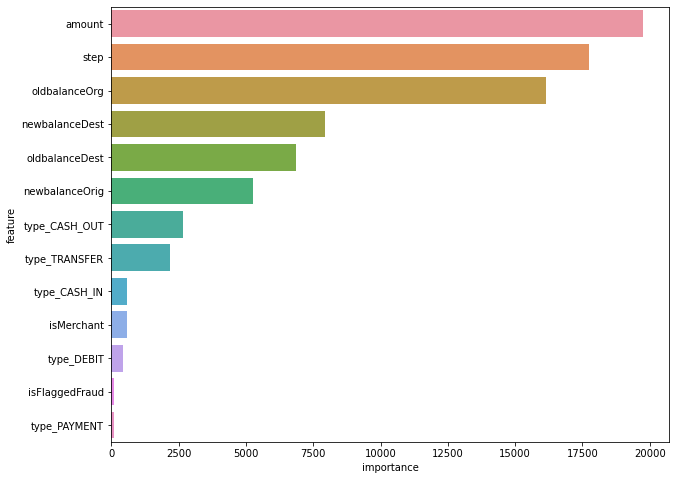

In [22]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = lgbm.feature_importances_
features = features.sort_values('importance', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,8))
sns.barplot(data=features, x='importance', y='feature');